In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import sklearn.decomposition
import scipy.stats as sc

def fix_unit(df,cols):
    for i in cols:

        ## fix unit M
        rs = df[df[i].str.match(pat = r'\d*.*\d*M')][i]
        if rs.shape[0]<1:
            pass
        else:
            to_rep = rs.values
            value = []
            for j in rs:
                idx = j.find('M')
                value.append(j[:idx])
            df[i].replace(to_replace = to_rep,value = value, inplace = True)

        ## fix unit K
        rs = df[df[i].str.match(pat = r'\d*.*\d*K')][i]
        if rs.shape[0]<1:
            pass
        else:
            to_rep = rs.values
            value = []
            for j in rs:
                idx = j.find('K')
                value.append(float(j[:idx])/1000)
            df[i].replace(to_replace = to_rep,value = value, inplace = True)

def df_astype(df,cols,type):
    for i in cols:
        df[i] = df[i].astype(type)
    return

def fix_Year(df):
    idx = df.query('Year < 1950').index.values
    to_rep = []
    var = []
    for i in range(idx.shape[0]):
        tmp = df.iloc[idx[i]]['Year']
        to_rep.append(tmp)
        if(tmp>50):
            var.append(tmp+1900)
        else:
            var.append(tmp+2000)
    df['Year'].replace(to_replace= to_rep,value = var, inplace = True)
    return

def drop_dup(df,subset_3):
    dname_idx = df[subset_3].value_counts()
    dname = dname_idx[df[subset_3].value_counts()>1]
    for i in range(dname.shape[0]):
        #print('(%s == "%s") and(%s == %d) and(%s == "%s")' %(subset_3[0],dname.index[i][0],subset_3[1],dname.index[i][1],subset_3[2],dname.index[i][2]))
        drop_dup_idx = df.query('(%s == "%s") and(%s == %d) and(%s == "%s")' %(subset_3[0],dname.index[i][0],subset_3[1],dname.index[i][1],subset_3[2],dname.index[i][2])).index.values
        df.drop(labels = drop_dup_idx, inplace= True)
    return

def scree_plot(array,len_arr):
  cmap = plt.cm.get_cmap('hsv',len_arr*3 )
  c = []
  arr_cum = []

  for i in range(len_arr):
    c.append(cmap(i))
  for i in range(len_arr):
    arr_cum.append(sum(array[:i+1]))
  plt.style.use("ggplot")
  plt.plot(arr_cum, label = 'Cumulative explanatory rate',marker = '.')
  plt.xlabel = ('PCA index')
  plt.ylabel = ('PCA explained variance ratio')
  plt.title("Scree plot")
  plt.legend(loc = 'best')
  plt.bar(x = range(len_arr), height = array,color = c)
  plt.show()

df = pd.read_csv('vgames2_g.csv')

year_null_idx = df[df.Year.isnull()].index.values
sales_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
drop_subset = ['Name','Year','Platform']

fix_unit(df,sales_cols)
df_astype(df,sales_cols,float)
fix_Year(df)
drop_dup(df,drop_subset)
df.to_csv('vgames2_h.csv')

df = pd.read_csv('vgames2_h.csv')
df['Whole_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']



C:\Users\user\AppData\Local\Temp\ipykernel_16720\831664184.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reg_ge_df = df.groupby('Genre').sum()


Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
NA_Sales,814.16,101.23,217.60,402.81,369.42,79.08,351.00,324.68,517.85,181.94,656.27,67.83
EU_Sales,502.64,63.88,99.36,215.28,186.55,45.15,234.71,186.70,300.23,113.18,361.92,44.64
JP_Sales,142.79,50.76,83.76,102.66,97.97,44.45,52.97,334.69,32.32,63.47,115.36,49.17
Other_Sales,181.38,16.94,36.07,74.48,48.86,11.38,76.54,57.58,98.79,31.43,130.56,11.19


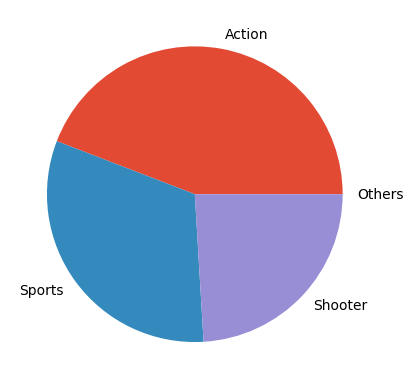

In [6]:
#### 지역에 따라서 선호하는 게임 장르 분석
## 지역별로 선호하는 게임의 장르가 같은가? 트렌드 분석
reg_ge_df = df.groupby('Genre').sum()
reg_ge_df.drop(['Unnamed: 0','Year','Whole_Sales'],axis = 1,inplace = True)
ge_reg_df = reg_ge_df.T
scaler2 = sklearn.preprocessing.StandardScaler()
ge_reg_df_scaled = scaler2.fit_transform(ge_reg_df)
pca2 = sklearn.decomposition.PCA()
score2 = pca2.fit_transform(ge_reg_df_scaled)
explained_varr2 = pca2.explained_variance_ratio_
# scree_plot(explained_varr2,len(explained_varr2))
pca2 = sklearn.decomposition.PCA(n_components=2)
score2 = pca2.fit_transform(ge_reg_df_scaled)
# sns.scatterplot(x = score2.T[0], y = score2.T[1],hue = ge_reg_df.T.columns.values)
# 유럽과 북아메리카가 서로 유사한 트렌드를 보이고 일본과 타 지역은 서로 다른 트렌드를 보임.
pref_df = reg_ge_df/reg_ge_df.sum()
na =pref_df['NA_Sales'].sort_values(ascending=False)[:3]
na = pd.concat([na,pd.Series(1-na.sum())])
eu =pref_df['EU_Sales'].sort_values(ascending=False)[:3]
eu = pd.concat([eu,pd.Series(1-na.sum())])
jp =pref_df['JP_Sales'].sort_values(ascending=False)[:3]
jp = pd.concat([jp,pd.Series(1-na.sum())])
ot =pref_df['Other_Sales'].sort_values(ascending=False)[:3]
ot = pd.concat([ot,pd.Series(1-na.sum())])

na_lable = np.append(pref_df['NA_Sales'].sort_values(ascending=False)[:3].index.values,'Others')
eu_lable = np.append(pref_df['EU_Sales'].sort_values(ascending=False)[:3].index.values,'Others')
jp_lable = np.append(pref_df['JP_Sales'].sort_values(ascending=False)[:3].index.values,'Others')
ot_lable = np.append(pref_df['Other_Sales'].sort_values(ascending=False)[:3].index.values,'Others')
# plt.pie(na,labels = na_lable)
# plt.pie(eu,labels = eu_lable)
# plt.pie(jp,labels = jp_lable)
plt.pie(ot,labels = ot_lable)
ge_reg_df

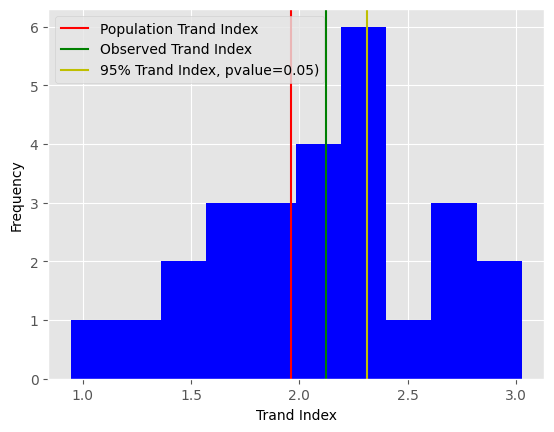

In [5]:
#### 연도별 게임의 트렌드가 있는가
## 가장 높은 출시 점유율을 가진 게임 장르의 트렌드 지수가 1.96보다 클 경우 트렌드가 있다고 가정.
## 트렌드 지수 = Xmax-m/sigma
## 귀무가설: 연도별 트렌드 지수가 1.96 보다 작거나 같다.
## 대립가설: 연도별 트렌드 지수가 1.96 보다 크다.
def trand_index(x,m,sigma):
    return (x-m)/sigma
df = df.dropna()
df = df.drop(df.query('(Year>2015)or(Year<1990)').index.values)
data = df.groupby('Year')['Genre'].value_counts(normalize = True)
t_obs = []
ilst = df['Year'].value_counts().index.values
for i in ilst:
    x = data[i][0]
    m = data[i].mean()
    s = data[i].std()
    t_obs.append(trand_index(x,m,s))
nn = 1.96
t = sc.ttest_1samp(a=t_obs,popmean=nn,alternative = 'greater')
plt.style.use("ggplot")
plt.hist(t_obs,color = 'b')
plt.xlabel('Trand Index')
plt.ylabel('Frequency')
plt.axvline(nn,label='Population Trand Index',color = 'r')
plt.axvline((sum(t_obs)/len(t_obs)),label='Observed Trand Index',color = 'g')
plt.axvline((sum(t_obs)/len(t_obs)+1.96*np.std(t_obs)/math.sqrt(len(t_obs))), label='95% Trand Index, pvalue=0.05)',color = 'y')
plt.legend()
round(t.pvalue,2)
# pvalue가 정확히 유의수준 0.05 이므로 귀무가설을 기각한다. 즉 연도별 트렌드 지수가 1.96보다 크다.
# 따라서 연도별 게임의 트렌드가 존재한다.
# 전체 게임 트렌드 지수:
ndata = df['Genre'].value_counts(normalize = True)
nTI = (ndata[0]-ndata.mean())/ndata.std()


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\User

Text(0, 0.5, 'Inertia')

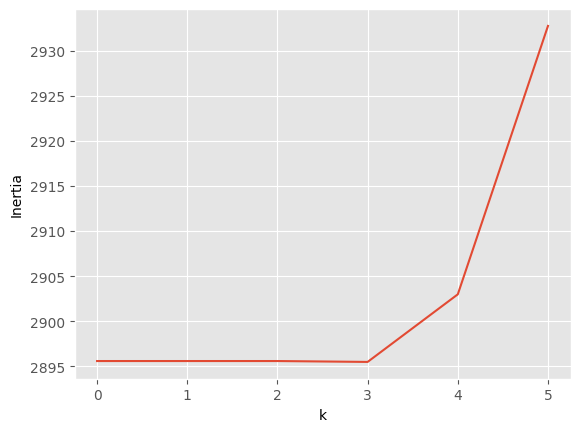

In [105]:
#### 인기가 많은 게임에 대한 분석
## 인기도 = 수요/|트렌드지수|
## 인기도가 평균보다 높은 게임을 인기가 많은 게임으로 정의.
##
data = df.groupby('Name')
ndf = pd.DataFrame()
ndf['NA_Sales'] = data['NA_Sales'].mean()
ndf['EU_Sales'] = data['EU_Sales'].mean()
ndf['JP_Sales'] = data['JP_Sales'].mean()
ndf['Other_Sales'] = data['Other_Sales'].mean()
lst = []
for i in range(6):
    km = sklearn.cluster.KMeans(n_clusters=4)
    km.fit(ndf)
    lst.append(km.inertia_)

plt.plot(lst)
plt.xlabel('k')
plt.ylabel('Inertia')


